<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%90%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B8_%D0%92%D0%BD%D1%83%D1%82%D1%80%D0%B5%D0%BD%D0%BD%D0%B5%D0%B5_%D0%BF%D1%80%D0%BE%D1%81%D1%82%D1%80%D0%B0%D0%BD%D1%81%D1%82%D0%B2%D0%BE_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ООО "Университет Цифровых Технологий платформа 3"

# Автокодировщики. Внутреннее пространство.

## Теория

Автокодировщик (англ. autoencoder) – нейронная сеть, обученная копировать свой вход в выход. Для обучения не требуется размеченная база - "обучение без учителя".

На внутреннем уровне в ней имеется скрытый слой $ z $, который
описывает код, используемый для представления входа. Можно считать, что сеть состоит из двух частей: кодировщика (encoder) c функцией кодирования $ z = g(x) $ и декодировщика (decoder), делающего реконструкцию входных данных $ r = f(z) $.

Кодировщик преобразует входные данные в скрытое пространство (с размерностью существенно меньше, чем у пространства входных данных). Декодер преобразует полученный вектор (точку) скрытого пространства обратно во входное представление. Цель обучения автокодировщика - добиться максимального совпадения входных и выходных данных.

Выходной слой автокодировщика должен иметь ту же размерность, что и входной слой.

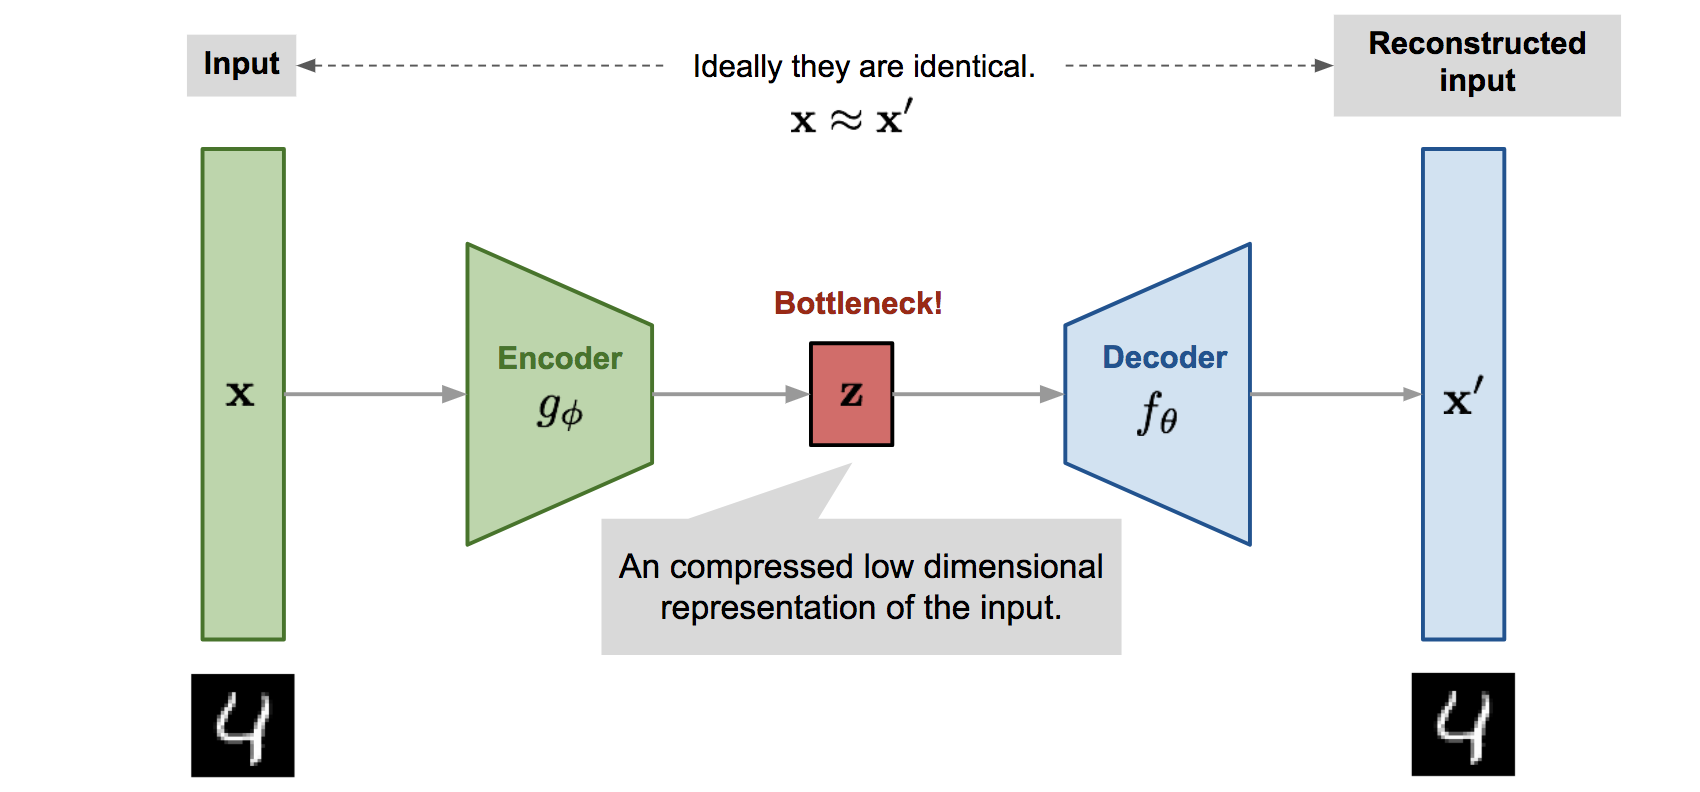

Существенный признак автоэнкодера - наличие 'bottleneck' - бутылочного горлышка, слоя с размерностью существенно меньшей, чем у водных данных. Этот слой содержит сжатое представление входных данных.

Применение автокодировщиков:

• улучшение качества изображения (увеличение четкости, шумоподавление, устранение дефектов т. д.),

• генерация новых данных по заданному образцу (например, раскрашивание черно-белых картинок в цветные),

• поиск выбросов и аномалий (например, мошеннических транзакций, ошибочных данных).

## Импорт библиотек

нам понадобятся классы keras, numpy и pandas. Для работы с изображениями импортируем OpenCV (как cv2). Также нам понадобится ряд системных библиотек.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils 
from tensorflow.keras.datasets import mnist, fashion_mnist

import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing import image 
import numpy as np 
import pandas as pd 
import random
from PIL import Image 
from sklearn.model_selection import train_test_split 
from skimage import color
import cv2

import os 
import time

## Пример автокодировщика

Рассмотрим автокодировщик на примере рукописных цифр MNIST: 

Он представляет собой композицию кодировщика и декодировщика. Кодировщик состоит из двух каскадов сверточных слоев, понижающих размерность изображения вдвое. Каждый каскад включает 2 сверточных слоя с ядрами 3 х 3 и слоя MaxPooling2D, понижающего размерность.

Сжатие в скрытое пространство размерностью latent_dim осуществляется полносвязным слоем.

Восстановление изображения происходит в обратном порядке - сначала скрытое состояние разжимается полносвязным слоем, преобразуется в размерность (7, 7, 64) для сверточных слоев. Удвоение размерности происходит за счет слоя Conv2DTranspose. Для регуляризации после каждого слоя используется слой BatchNormalization.

Выход декодера имеет ту же размерность, что и вход энкодера. Используется активация sigmoid, поскольку все выходные сигналы должны лежать в диапазоне от 0 до 1.

Модель автоэнкодера (ae) определяется как композиция энкодера и декодера.

Функция возвращает все три модели в виде кортежа.


In [ ]:
def convAutoencoder(latent_dim=100, shape=(28, 28, 1), optimizer=Adam(lr=0.0001)): 
    img_input = Input(shape=shape) 
    z_input = Input(shape=(latent_dim,))

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) 
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = MaxPooling2D()(x) # 14x14x32

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)  
    x = BatchNormalization()(x) 
    x = MaxPooling2D()(x) # 7x7x64
    x = Flatten()(x)
    
    z = Dense(latent_dim)(x) # Выход слоя образует скрытое (latent) пространство.

    encoder = Model(img_input, z)

    x = Dense(7*7*64)(z_input)
    x = Reshape((7, 7, 64))(x)
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 

    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 

    out = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    decoder = Model(z_input, out)

    ae = Model(img_input, decoder(encoder(img_input))) 
    
    ae.compile(optimizer=optimizer, loss='mean_squared_error') 

    return ae, encoder, decoder 

Загрузим рукописные цифры из стандартного keras-датасета и сделаем предобработку данных.

В исходном виде данные кодируются целыми числами от 0 до 255, преобразуем их в числа с плавающей запятой в диапазоне от 0 до 1.

Добавим размерность, равную 1, соответствующую номеру канала. Это нужно для сверточных слоев.

In [ ]:
(xTrain, yTrain), (xTest, yTest) = mnist.load_data() 
xTrain = xTrain.astype('float32')/255 # представляем в виде значений от 0 до 1
xTrain = xTrain[..., None] # меняем форму, приводим к нужным нам размерам
xTest = xTest.astype('float32')/255 # представляем в виде значений от 0 до 1
xTest = xTest[..., None] # меняем форму, приводим к нужным нам размерам
xTrain.shape, xTest.shape, yTrain.shape, yTest.shape # выведем размерности данных

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28, 1), (10000, 28, 28, 1), (60000,), (10000,))

Создадим экземпляр автоэнкодера и обучим его:

In [ ]:
%%time
mnistAE, encoder, decoder = convAutoencoder() 
mnistAE.summary()
history = mnistAE.fit(xTrain, xTrain, epochs=60, batch_size=1000, validation_data=(xTest[:2000], xTest[:2000]))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Functional)           (None, 100)               379460    
_________________________________________________________________
model_1 (Functional)         (None, 28, 28, 1)         435201    
Total params: 814,661
Trainable params: 813,701
Non-trainable params: 960
_________________________________________________________________
Epoch 1/60
60/60 [==============================] - 44s 162ms/step - loss: 0.2041 - val_loss: 0.1264
Epoch 2/60
60/60 [==============================] - 9s 155ms/step - loss: 0.0965 - val_loss: 0.0963
Epoch 3/60
60/60 [==============================] - 9s 157ms/step - loss: 0.0707 - val_loss: 0.0929
Epoch 4/60
60/60 [==============================] - 10s 159ms/step - loss: 0.055

Построим график обучения.

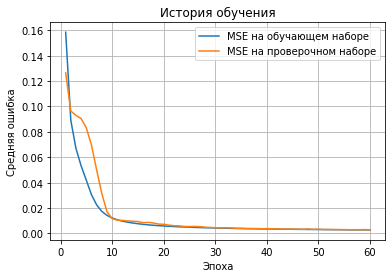

In [ ]:
ep = [i+1 for i in range(len(history.history['loss']))]
plt.plot(ep, history.history['loss'], label='MSE на обучающем наборе')
plt.plot(ep, history.history['val_loss'], label='MSE на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.xlabel('Эпоха')
plt.title('История обучения')
plt.grid()
plt.legend()
plt.show()

Сравним результат работы автокодировщика с оригиналом. Проверяем на тестовых данных, которые модель не видела при обучении.


In [ ]:
pred = mnistAE.predict(xTest) 

Создадим функцию для сравнения картинок. Верхний ряд - исходные изображения, внизу - на выходе автокодировщика. Картинки выбираются случайным образом.

In [ ]:
def plotImages(y, pred, n=6, figsize=(16,4)): 
    plt.figure(figsize=figsize) 
    for i in range(n): 
        index = np.random.randint(0, pred.shape[0]) # выбираем картинки случайно
        # Показываем исходные картинки
        ax = plt.subplot(2, n, i + 1) 
        plt.imshow(y[index].squeeze(axis=-1), cmap='gray') 
        # Показываем восстановленные картинки
        ax = plt.subplot(2, n, i + 1 + n)  
        plt.imshow(pred[index].squeeze(axis=-1), cmap='gray')     
    plt.show()

Выведем результат работы автоэнкодера.

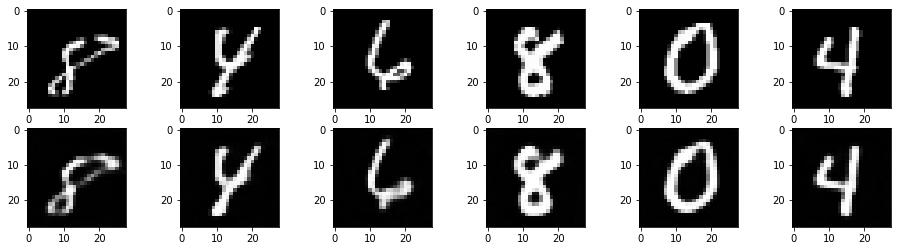

In [ ]:
plotImages(xTest, pred)

Вычислим средний квадрат ошибки:

In [ ]:
mnistAE.evaluate(xTest, xTest)

313/313 [==============================] - 1s 3ms/step - loss: 0.0028


0.002761186333373189

Метод evaluate вычисляет средний квадрат ошибки как в данном выражении:

In [ ]:
MSE = np.mean((xTest - pred)**2) 
print(MSE)

0.0027611852


Посмотрим, что произойдет, если применить автокодировщик, обученный на базе рукописных цифр, к другой базе, например Fashion MNIST.

Загрузим датасет, сделаем такую же предобработку данных:

In [ ]:
(_, _), (xTest2, yTest2) = fashion_mnist.load_data() 
xTest2 = xTest2.astype('float32')/255 # представляем в виде значений от 0 до 1
xTest2 = xTest2.reshape(-1, 28, 28, 1) # меняем форму, приводим к нужным нам размерам

4423680/4422102 [==============================] - 0s 0us/step


Применим автоэнкодер и оценим среднюю ошибку:

In [ ]:
mnistAE.evaluate(xTest2, xTest2)

313/313 [==============================] - 1s 3ms/step - loss: 0.0613


0.06127888709306717

Видим, что ошибка на "нетипичных" данных возросла более чем в 20 раз. Эта особенность позволяет детектировать выбросы, аномалии, ошибочные входные данные.

Посмотрим как автоэнкодер справится с задачей восстановления изображений fashion MNIST

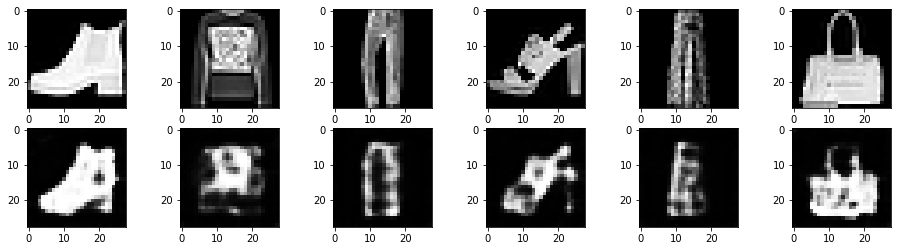

In [ ]:
pred2 = mnistAE.predict(xTest2)
plotImages(xTest2, pred2)

Качество восстановления изображений значительно ухудшилось, поскольку автокодировщик обучался на непохожих данных.

## Подавление шума

Одно из главных практических применений автоэнкодеров - очистка изображений (и других типов данных) от шумов, мелких дефектов.

Рассмотрим случай обучения на зашумленных данных. Добавим шум к тренировочным и тестовым данным MNIST:

будем моделировать шум случайными числами с нормальным распределением.

In [ ]:
noise1 = np.random.normal(0, 0.2, xTrain.shape)
noise2 = np.random.normal(0, 0.2, xTest.shape)
xTrainNoised = np.clip(xTrain + noise1, 0., 1.) # np.clip отсекает то, что вышло за допустимые пределы из-за шума
xTestNoised = np.clip(xTest + noise2, 0., 1.)

Обучим тот же самый автоэнкодер на зашумленных данных:

In [ ]:
%%time
noisedAE, encoder, decoder = convAutoencoder() 
history = noisedAE.fit(xTrainNoised, xTrainNoised, epochs=60, batch_size=1000, validation_data=(xTestNoised[:2000], xTestNoised[:2000]))

Epoch 1/60
60/60 [==============================] - 11s 163ms/step - loss: 0.1413 - val_loss: 0.1718
Epoch 2/60
60/60 [==============================] - 10s 161ms/step - loss: 0.0523 - val_loss: 0.2624
Epoch 3/60
60/60 [==============================] - 10s 162ms/step - loss: 0.0431 - val_loss: 0.2379
Epoch 4/60
60/60 [==============================] - 10s 161ms/step - loss: 0.0387 - val_loss: 0.1245
Epoch 5/60
60/60 [==============================] - 10s 161ms/step - loss: 0.0338 - val_loss: 0.0632
Epoch 6/60
60/60 [==============================] - 10s 160ms/step - loss: 0.0296 - val_loss: 0.0394
Epoch 7/60
60/60 [==============================] - 10s 160ms/step - loss: 0.0267 - val_loss: 0.0307
Epoch 8/60
60/60 [==============================] - 10s 160ms/step - loss: 0.0232 - val_loss: 0.0247
Epoch 9/60
60/60 [==============================] - 10s 160ms/step - loss: 0.0220 - val_loss: 0.0226
Epoch 10/60
60/60 [==============================] - 10s 160ms/step - loss: 0.0215 - val_lo

Теперь потери восстановления стали более высокие, чем в случае без шума.

In [ ]:
pred3 = noisedAE.predict(xTestNoised)

Посмотрим как автоэнкодер восстанавливает зашумленные данные:

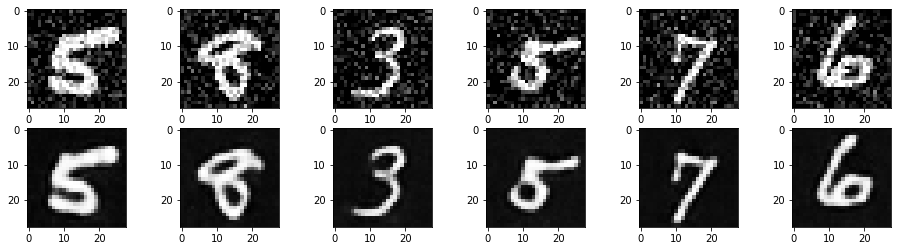

In [ ]:
plotImages(xTestNoised, pred3)

Шум удалаяется, но ценой некоторого размытия картинки

## Детектирование выбросов

Автокодировщики могут применяться для обнаружения выбросов, нетипичных, ошибочных данных.
Характерной особенностью таких данных является то, что автокодировщик не может их восстановить с той же точностью, как и типичные данные, на которых он был обучен.

Рассмотрим классический пример использования автокодировщика для обнаружения мошеннических операций с кредитными картами. Данные по транзакциям взяты с [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud)

In [ ]:
!wget https://xland.ru/datasets/creditcard.zip

--2021-05-01 01:59:54--  https://xland.ru/datasets/creditcard.zip
Resolving xland.ru (xland.ru)... 198.211.125.59
Connecting to xland.ru (xland.ru)|198.211.125.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69155672 (66M) [application/zip]
Saving to: ‘creditcard.zip’

creditcard.zip      100%[===================>]  65.95M  26.0MB/s    in 2.5s    

2021-05-01 01:59:57 (26.0 MB/s) - ‘creditcard.zip’ saved [69155672/69155672]



Разархивируем данные в CSV файл.

In [ ]:
!unzip creditcard.zip

Archive:  creditcard.zip
  inflating: creditcard.csv          


Прочитаем CSV файл в DataFrame pandas и выведем образец:

In [ ]:
df = pd.read_csv('creditcard.csv')

In [ ]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Зафиксируем сиды для всех 3-х типов используемых генераторов случайных чисел. Делаем это для воспроизводимости результатов.

In [ ]:
RANDOM_SEED = 42
TRAINING_SAMPLE = 200000
VALIDATE_SIZE = 0.2

# установки для воспроизводимости результатов
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

Сделаем некоторые преобразование датафрейма - приведем все названия колонок к нижнему регистру, 

нормализуем данные колонки 'amount' путем взятия десятичного логарифма. 

Вычитанием константы 1.3 мы делаем среднее значение близким к нулю.

Удаляем ненужные колонки.

In [ ]:
df.columns = map(str.lower, df.columns)
df.rename(columns={'class': 'label'}, inplace=True)
df['log10_amount'] = np.log10(df.amount + 0.001) - 1.3
# удалим ненужные колонки
df = df.drop(['time', 'amount'], axis=1)
# выведем 5 первых строк
df.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,label,log10_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.874993
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.870086
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.278251
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.791670
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.545042


In [ ]:
df.log10_amount.mean()

-0.02226710648891325

Разобьем данные на 2 части - мошеннические (fraud) и нормальные (clean)

In [ ]:
fraud = df[df.label == 1]
clean = df[df.label == 0]

Посмотрим какой процент мошеннических операций:

In [ ]:
len(fraud)/len(df)*100

0.1727485630620034

Будем обучать автоэнкодер на нормальных (не мошеннических) операциях. Для тестирования работы автоэнкодера отберем тестовые данные, состоящие из всех мошеннических операций и сопоставимого числа нормальных. 

In [ ]:
df_train = df.drop(['label'], axis=1)

In [ ]:
df_train.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,log10_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.874993
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.870086
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.278251
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.791670
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.545042


Отделим для тестов небольшую часть , сопоставимую с числом мошеннических операций ( 1%)

In [ ]:
x_train, x_clean = train_test_split(df_train.values, test_size=0.01, random_state=RANDOM_SEED)

In [ ]:
x_train.shape, x_clean.shape

((281958, 29), (2849, 29))

Создадим энкодер в виде 2-х полносвязных слоев.
 
Мы выбрали размерность скрытого пространства равной 2. Это сделано исключительно для возможности наглядного представления распределения точек. Однако для более точной работы автоэнкодера следует использовать скрытые пространства с большей размерностью, например 10.

In [ ]:
latent_dim = 2
inp = Input(shape=(29,))
h1 = Dense(512, activation='relu')(inp)
z = Dense(latent_dim)(h1)
encoder = Model(inp, z)

In [ ]:
encoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               15360     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
Total params: 16,386
Trainable params: 16,386
Non-trainable params: 0
_________________________________________________________________


Аналогично создаем декодер

In [ ]:
inp_z = Input(shape=(latent_dim,))
h2 = Dense(512, activation='relu')(inp_z)
out = Dense(29)(h2)
decoder = Model(inp_z, out)

In [ ]:
decoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_7 (Dense)              (None, 29)                14877     
Total params: 16,413
Trainable params: 16,413
Non-trainable params: 0
_________________________________________________________________


Определим автоэнкодер как композицию энкодера и декодера:

In [ ]:
ae = Model(inp, decoder(encoder(inp)))

Компилируем автоэнкодер:

In [ ]:
ae.compile(optimizer=Adam(lr=0.001), loss='mse', metrics=['mae'])

И запускаем обучение.

In [ ]:
history = ae.fit(x_train, x_train, epochs=300, batch_size=1024, validation_split=0.1)

Epoch 1/300
248/248 [==============================] - 1s 3ms/step - loss: 0.8390 - mae: 0.5907 - val_loss: 0.6479 - val_mae: 0.5283
Epoch 2/300
248/248 [==============================] - 1s 3ms/step - loss: 0.6468 - mae: 0.5203 - val_loss: 0.5820 - val_mae: 0.5077
Epoch 3/300
248/248 [==============================] - 1s 3ms/step - loss: 0.5751 - mae: 0.5030 - val_loss: 0.5585 - val_mae: 0.4992
Epoch 4/300
248/248 [==============================] - 1s 3ms/step - loss: 0.5548 - mae: 0.4980 - val_loss: 0.5304 - val_mae: 0.4927
Epoch 5/300
248/248 [==============================] - 1s 3ms/step - loss: 0.5263 - mae: 0.4902 - val_loss: 0.5165 - val_mae: 0.4873
Epoch 6/300
248/248 [==============================] - 1s 3ms/step - loss: 0.5127 - mae: 0.4849 - val_loss: 0.5095 - val_mae: 0.4830
Epoch 7/300
248/248 [==============================] - 1s 3ms/step - loss: 0.5044 - mae: 0.4810 - val_loss: 0.4940 - val_mae: 0.4759
Epoch 8/300
248/248 [==============================] - 1s 3ms/step - 

Создадим numpy-массив (492, 29) мошеннических операций

In [ ]:
x_fraud = fraud.drop(['label'], axis=1).values
x_fraud.shape

(492, 29)

Сравним точности восстановления на нормальных и мошеннических операциях:

In [ ]:
pred_clean = ae.evaluate(x_clean, x_clean)
pred_fraud = ae.evaluate(x_fraud, x_fraud)

16/16 [==============================] - 0s 2ms/step - loss: 1.9918 - mae: 0.9129


Точность на нормальных данных на порядок выше.

In [ ]:
pred_clean, pred_fraud

([0.32332876324653625, 0.3851739466190338],
 [1.9918252229690552, 0.9128687977790833])

Посмотрим распределение точек в скрытом пространстве (для возможности визуализации мы уменьшили его размерность до 2, что снизило точность восстановления)

In [ ]:
z_clean = encoder.predict(x_clean)
z_fraud = encoder.predict(x_fraud)

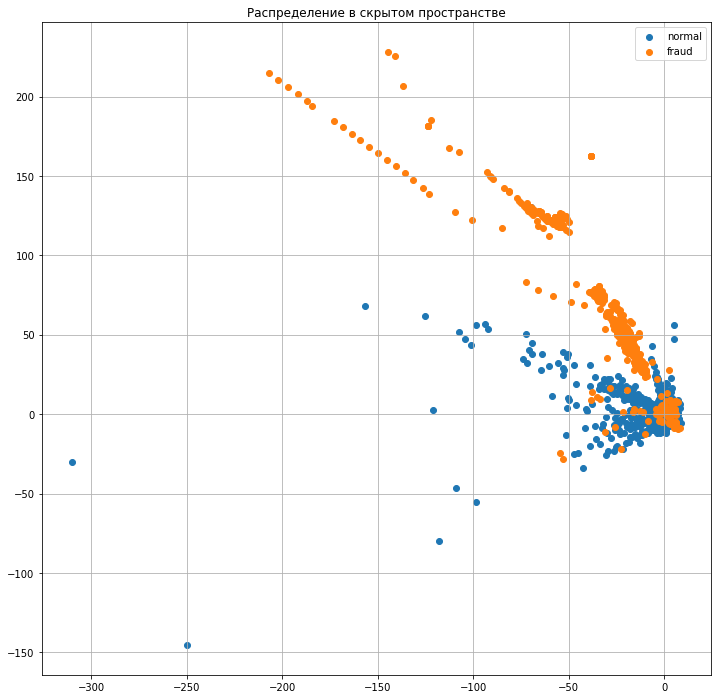

In [ ]:
plt.figure(figsize=(12, 12))
plt.scatter(z_clean[:, 0], z_clean[:, 1], label='normal')
plt.scatter(z_fraud[:, 0], z_fraud[:, 1], label='fraud')
plt.grid()
plt.legend()
plt.title('Распределение в скрытом пространстве')
plt.show()

Из графика видно, что распределение точек в скрытом пространстве сильно отличается для нормальных и мошеннических операций. В то же время эти распределения частично перекрываются, поэтому автоэнкодер не может выявить все мошеннические операции.

Следует заметить, что конкретная картина распределения точек будет зависеть от начальной инициализации весов модели и каждый раз будет другой. 
 
Сохраним образец распределения для сравнения с другими прогонами:

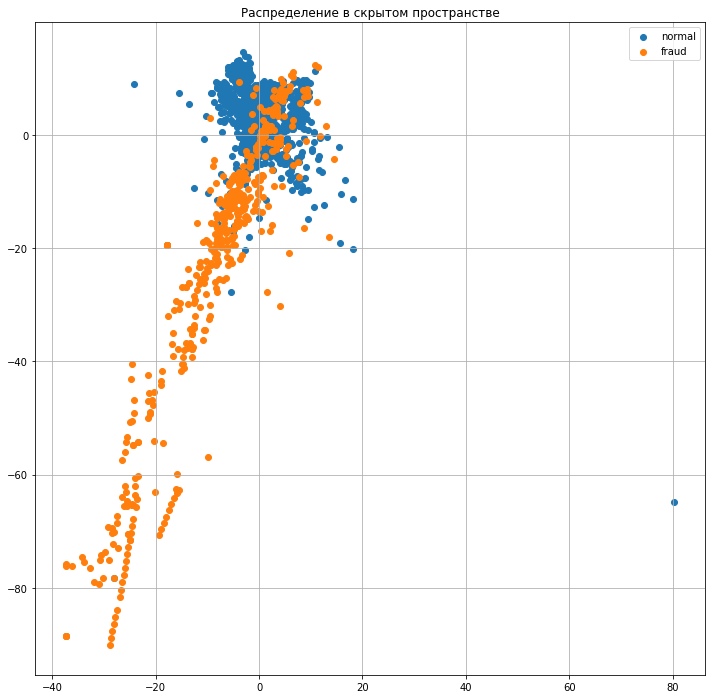

Создадим функцию для проверки транзакции:

In [ ]:
def detectFraud(ae, x, std, threshold=2):
    """
    :param ae: автоэнкодер (модель keras)
    :param x: данные для проверки (размерности (1, 29))
    :param std: среднеквадратичная ошибка автоэнкодера на нормальных данных
    :param threshold: порог - параметр критерия. Операция считается мошеннической, если ошибка восстановления превышает среднюю более чем threshold раз.
    :return: True for fraud, False for normal. 
    """
    pred = ae.predict(x)
    e = (pred - x)**2
    mse = e.mean()
    return mse > threshold * std

Применим нашу функцию к мошенническим операциям:

In [ ]:
%%time
std = 0.32
count = 0
for x in x_fraud:
    x = x.reshape(1, 29)
    if detectFraud(ae, x, std, 3):
        count += 1
print("Выявлено мошеннических операций: %d, всего: %d (%.1f%%)" % (count, len(x_fraud), 100 * count / len(x_fraud)))

Выявлено мошеннических операций: 325, всего: 492 (66.1%)
CPU times: user 13.8 s, sys: 499 ms, total: 14.3 s
Wall time: 14 s


и к нормальным операциям:

In [ ]:
%%time
count = 0
for x in x_clean:
    x = x.reshape(1, 29)
    if detectFraud(ae, x, std, 3):
        count += 1
print("Выявлено мошеннических операций: %d, всего: %d (%.1f%%)" % (count, len(x_clean), 100 * count / len(x_clean)))

Выявлено мошеннических операций: 117, всего: 2849 (4.1%)
CPU times: user 1min 20s, sys: 2.98 s, total: 1min 23s
Wall time: 1min 22s


С уменьшением порога threshold увеличивается процент выявленных мошеннических транзакций, однако одновременно с этим увеличивается число ложных срабатываний на нормальных операциях.

## Раскраска изображений

Раскраска черно-белых изображений - одно из интересных применений автоэнкодеров. 

При обучении применяется несколько нестандартный подход - на вход подается черно-белое изображение, а выход сравнивается с цветным. Автоэнкодер учится распознавать характерные черно-белые объекты (детали изображения) и запоминать их цвет.

Для обучения используем кадры первого ролика.
Будем раскрашивать черно-белые изображения - кадры из 2-го видео ролика.

В обих роликах снимались одни и те же объекты, но несколько с разных точек и расстояний.

https://xland.ru/uai/hw09/Video/12.mp4 - видео для обучения (можно посмотреть перейдя по ссылке)

https://xland.ru/uai/hw09/Video/13.mp4 - для раскраски

импортируем видео для обучения и раскраски


In [ ]:
!wget https://xland.ru/uai/hw09/Video/12.mp4
!wget https://xland.ru/uai/hw09/Video/13.mp4

--2021-05-01 02:05:13--  https://xland.ru/uai/hw09/Video/12.mp4
Resolving xland.ru (xland.ru)... 198.211.125.59
Connecting to xland.ru (xland.ru)|198.211.125.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13981862 (13M) [video/mp4]
Saving to: ‘12.mp4’

12.mp4              100%[===================>]  13.33M  15.5MB/s    in 0.9s    

2021-05-01 02:05:14 (15.5 MB/s) - ‘12.mp4’ saved [13981862/13981862]

--2021-05-01 02:05:15--  https://xland.ru/uai/hw09/Video/13.mp4
Resolving xland.ru (xland.ru)... 198.211.125.59
Connecting to xland.ru (xland.ru)|198.211.125.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6565822 (6.3M) [video/mp4]
Saving to: ‘13.mp4’

13.mp4              100%[===================>]   6.26M  9.43MB/s    in 0.7s    

2021-05-01 02:05:16 (9.43 MB/s) - ‘13.mp4’ saved [6565822/6565822]



Считываем обучающие изображения средствами библиотеки OpenCV:

In [ ]:
# 
file = '12.mp4'
cap = cv2.VideoCapture(file)

Метод get позволяет получить характеристики записи, такие как формат изображения, частоту кадров, тип кодека, полное число кадров, например:

In [ ]:
# получаем характеристики записи (только для примера)
for i in range(2,8):
    print( cap.get(i))

1.1111111111111112e-05
640.0
480.0
30.02145102017061
828601953.0
1003.0


делаем из видео массив изображений 224х224 для обучения

In [ ]:
currentFrame = 0
frames = []
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    clip = frame[16:464, 96:544, :]  # вырезаем из фрейма 640x480 клип 448x448
    frames.append(cv2.resize(clip, (224, 224))) # уменьшаем до 224х224
    if currentFrame % 100 == 0:
        print (currentFrame, end=' ')
    currentFrame += 1
print()
cap.release()
cv2.destroyAllWindows()
x_train_rgb = np.array(frames).astype('float32')/255. # нормируем
x_train_rgb.shape

0 100 200 300 400 500 600 700 800 900 1000 


(1003, 224, 224, 3)

То же самое делаем с видео для раскраски. 

Выводим каждый сотый кадр в качестве образцов.

0


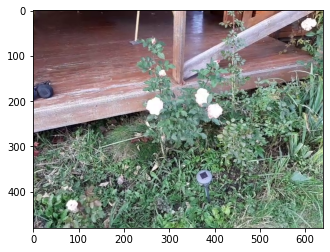

100


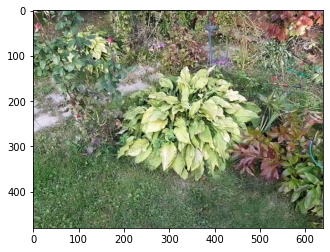

200


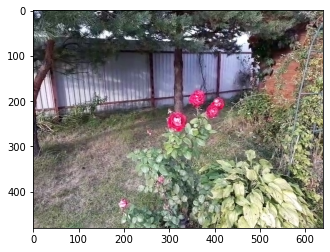

300


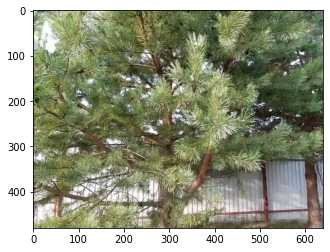

400


(470, 224, 224, 3)

In [ ]:
# делаем из видео массив изображений 224х224 для раскраски
file = '13.mp4'
cap = cv2.VideoCapture(file)
currentFrame = 0
frames = []
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    clip = frame[16:464, 96:544, :]  # вырезаем из фрейма 640x480 клип 448x448
    frames.append(cv2.resize(clip, (224, 224)))
    if currentFrame % 100 == 0:
        print (currentFrame)
    currentFrame += 1
    if currentFrame % 100 == 0:
        plt.imshow(frame, cmap='gray')
        # plt.imshow(frames[-1])
        plt.show()
cap.release()
cv2.destroyAllWindows()
x_test_rgb = np.array(frames).astype('float32')/255. # нормируем
x_test_rgb.shape

Функция для создания автоэнкодера для раскраски. Стого говоря, это не совсем автоэнкодер, поскольку формат входных и выходных данных разный. Но архитектура очень похожая.

In [ ]:
def paintAutoencoder(shape=(224, 224, 1)): 
    inp = Input((shape)) 

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inp) 
    x = BatchNormalization()(x)  
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = MaxPooling2D()(x) 

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x)  
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)  
    x = BatchNormalization()(x) 
    x = MaxPooling2D()(x) 
    
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x)  
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    z = MaxPooling2D()(x) # 28x28

    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', activation='relu')(z) # 56x56
    x = BatchNormalization()(x) 
    
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) # 112x112
    x = BatchNormalization()(x) 

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) # 224x224
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 

    out = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

    model = Model(inp, out) 
    model.compile(optimizer=Adam(lr=0.0001), loss='mse') 

    return model 

Используется активация tanh, дающая на выходе значение от -1 до 1. Это связано с тем, что мы будем использовать т.н. Lab-кодирование цветов и яркости. В этой кодировке сигналы цветности a и b могут принимать отрицательные значения.

In [ ]:
model_paint = paintAutoencoder()
model_paint.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 224, 224, 64)      640       
_________________________________________________________________
batch_normalization_20 (Batc (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_21 (Batc (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 112, 112, 128)     7385

```
x_train_rgb - учебные изображения в палитре RGB
x_train_lab - учебные изображения в палитре Lab
x_train_gray - черно-белые учебные изображения

x_test_rgb - исходные тестовые изображения в палитре RGB
x_test_lab - исходные тестовые изображения в палитре Lab
x_test_gray - черно-белые тестовые изображения для раскраски

x_pred_lab - предсказание (раскраска) в палитре Lab
x_pred_rgb - предсказание (раскраска) в палитре RGB

```

Преобразуем изображения в кодировке RGB в кодировку Lab (L-яркость, a,b - цветность)
Использование такой кодировки облегчает обучение.

Создадим черно-белые изображения для раскраски.

In [ ]:
# Наборы для обучения
x_train_lab = color.rgb2lab(x_train_rgb)/100
x_train_gray = x_train_lab[:, :, :, :1]
# Наборы для раскраски
x_test_lab = color.rgb2lab(x_test_rgb)/100
x_test_gray = x_test_lab[:, :, :, :1]

Этот класс позволяет строить единый график обучения если обучение делается в несколько этапов.

In [ ]:
# Класс строит график всего обучения, состоявшего из нескольких этапов.
class LearnHistory:
    def __init__(self):
        self.history = {'loss':[], 'val_loss': []}

    def append(self, history):
        self.history['loss'].extend(history.history['loss'])
        self.history['val_loss'].extend(history.history['val_loss'])

    def plot(self, ylim=None):
        ep = [i+1 for i in range(len(self.history['loss']))]
        plt.plot(ep, self.history['loss'], label='MSE на обучающем наборе')
        plt.plot(ep, self.history['val_loss'], label='MSE на проверочном наборе')
        plt.ylabel('Средняя ошибка')
        plt.xlabel('Эпоха')
        if ylim is not None:
            plt.ylim(0, ylim)
        plt.title('История обучения')
        plt.grid()
        plt.legend()
        plt.show()

Будем сохранять лучшие веса по ходу обучения

In [ ]:
dir = '/content/'
save_path_paint = dir+'best_model_paint.h5'
ckp = ModelCheckpoint(save_path_paint, monitor='val_loss', save_best_only=True, verbose=1)
lh = LearnHistory()

In [ ]:
model_paint.compile(optimizer=Adam(lr=0.0001), loss='mse') 

Обучим модель. На вход подаем L - яркость, на выход - яркость L + цветности a,b.

Epoch 1/100
101/101 [==============================] - 48s 409ms/step - loss: 0.2873 - val_loss: 0.0315

Epoch 00001: val_loss improved from inf to 0.03150, saving model to /content/best_model_paint.h5
Epoch 2/100
101/101 [==============================] - 37s 365ms/step - loss: 0.0394 - val_loss: 0.0259

Epoch 00002: val_loss improved from 0.03150 to 0.02591, saving model to /content/best_model_paint.h5
Epoch 3/100
101/101 [==============================] - 38s 372ms/step - loss: 0.0261 - val_loss: 0.0230

Epoch 00003: val_loss improved from 0.02591 to 0.02299, saving model to /content/best_model_paint.h5
Epoch 4/100
101/101 [==============================] - 37s 368ms/step - loss: 0.0228 - val_loss: 0.0209

Epoch 00004: val_loss improved from 0.02299 to 0.02087, saving model to /content/best_model_paint.h5
Epoch 5/100
101/101 [==============================] - 38s 372ms/step - loss: 0.0165 - val_loss: 0.0194

Epoch 00005: val_loss improved from 0.02087 to 0.01936, saving model to /co

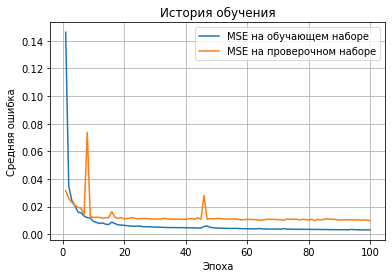

CPU times: user 27min 39s, sys: 20min 59s, total: 48min 38s
Wall time: 1h 2min 43s


In [ ]:
%%time
history = model_paint.fit(x_train_gray, x_train_lab, epochs=100, batch_size=10, callbacks=[ckp], validation_data=(x_test_gray, x_test_lab), validation_batch_size=10) 
lh.append(history)
lh.plot()

Загрузим лучшие сохраненные веса

In [ ]:
model_paint.load_weights(save_path_paint)

Оценим точность раскраски

In [ ]:
score = model_paint.evaluate(x_test_gray, x_test_lab)
score

15/15 [==============================] - 18s 724ms/step - loss: 0.0098


0.009837777353823185

Раскрасим картинки используя палитру Lab

In [ ]:
# Раскраска
x_pred_lab_ = model_paint.predict(x_test_gray)*100

In [ ]:
# Своя функция, color.lab2rgb спотыкается на нашей размерности
def my_lab2rgb(lab):
    '''Transforms Lab to RGB np array
        Lab in 0.-100. scale, RGB in 0.0-1.0 scale
    ''' 
    rgb = np.zeros_like(lab)
    for i in range(len(lab)):
        z = color.lab2rgb(lab[i])
        rgb[i] = z
    return rgb

Преобразуем в кодировку RGB:

In [ ]:
x_pred_rgb = my_lab2rgb(x_pred_lab_)

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Функция для визуализации результатов:

In [ ]:
# для вывода исходной, черно-белой и раскрашенной картинок.

def plotPaintedImages(original, gray, painted, n=5, figsize=(20, 12)):
    plt.figure(figsize=figsize)
    for i in range(n):
        # index = np.random.randint(painted.shape[0])
        index = i*100 + 50
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original[index])
        plt.title(f'original #{index}')

        ax = plt.subplot(3, n, i + n + 1)
        plt.imshow(gray[index], cmap='gray')
        plt.title('grayscaled')
        
        ax = plt.subplot(3, n, i + 2*n + 1)
        plt.imshow(painted[index])
        plt.title('painted')

    plt.show()

Выводим контрольные кадры из тестового набора

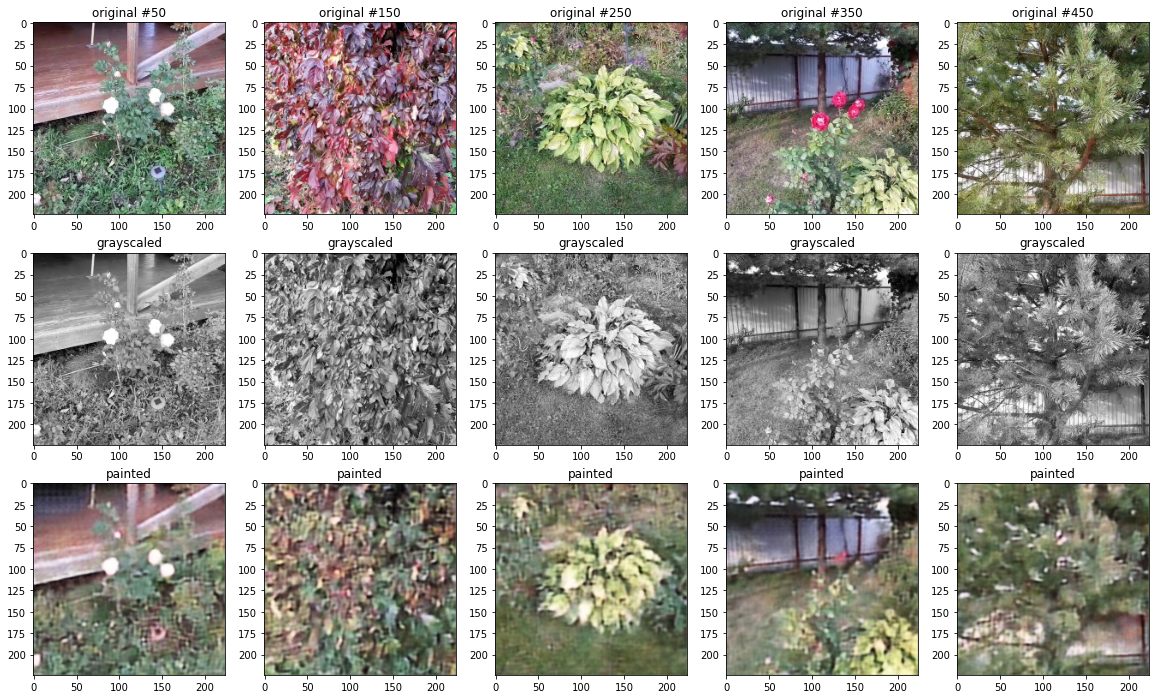

In [ ]:
plotPaintedImages(x_test_rgb, x_test_gray.reshape(470,224,224), x_pred_rgb)

**ВЫВОДЫ**

Для получения хороших результатов обучающие изображения должны быть очень похожими на раскрашиваемые. В целом раскрашивание хорошо работает на однородных крупных деталях. Тонкая структура несколько размывается. Мелкие детали, имеющие сильный цветовой контраст с фоном, раскрашиваются плохо (пример - красные розы) На черно-белом изображении красные розы почти не отличимы от фона, и модель их не увидела.

Вопросы для исследований:
1. Какова емкость памяти модели? Сколько модель может запомнить новых различных изображений, фактур прежде чем начнет забывать старые? Хотелось бы оценить коэффициент пропорциональности между числом параметров модели и информационным объемом (энтропией) запоминаемых изображений.
2. Какой минимальной "толщины" может/должна быть "талия" у автоэнкодера? Как она влияет на способность запоминать цветовые детали?

#Литература

1. https://www.tensorflow.org/tutorials/generative/autoencoder
2. https://medium.com/analytics-vidhya/autoencoders-with-tensorflow-2f0a7315d161
3. https://www.pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/
4. https://blog.keras.io/building-autoencoders-in-keras.html
5. https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html


##End